In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from torch.multiprocessing.spawn import spawn
import torchvision.models as models
import torchvision.datasets as dst
from torchvision.io import read_image
from torchvision.transforms import v2

In [5]:
def transform_for_sketch(img):
    transforms = v2.Compose([
        v2.Grayscale(num_output_channels=1), #念の為
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,), (0.5,))   # [0,1]→[-1,1]
    ])
    return transforms(img)

class Generator(nn.Module):
    def __init__(self, in_ch=1, out_ch=3, features=64):
        super().__init__()
        def down(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)]
            if normalize: layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2,True))
            return nn.Sequential(*layers)
        def up(in_c, out_c, dropout=False):
            layers = [
                nn.ConvTranspose2d(in_c, out_c,4,2,1,bias=False),
                nn.InstanceNorm2d(out_c),
                nn.ReLU(True)
            ]
            if dropout: layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        # → 128→64→32→16→8→4→2→1 (7 downs: down1..down7)
        self.down1 = down(in_ch,    features, normalize=False)
        self.down2 = down(features, features*2)
        self.down3 = down(features*2, features*4)
        self.down4 = down(features*4, features*8)
        self.down5 = down(features*8, features*8)
        self.down6 = down(features*8, features*8)
        self.down7 = down(features*8, features*8, normalize=False)  # 2→1

        # 7 ups, 最終で 1→128
        self.up1 = up(features*8,        features*8, dropout=True)           # 512 → 512
        self.up2 = up(features*8*2,      features*8, dropout=True)           # 1024→512
        self.up3 = up(features*8*2,      features*8, dropout=True)           # 1024→512
        self.up4 = up(features*8*2,      features*8)                         # 1024→512
        # 512 + 256 = 768
        self.up5 = up(features*8 + features*4, features*4)                   # 768 →256
        # 256 + 128 = 384
        self.up6 = up(features*4 + features*2, features*2)                   # 384 →128
        # 128 + 64 = 192
        self.up7 = nn.Sequential(
            nn.ConvTranspose2d(features*2 + features, out_ch, 4, 2, 1),      # 192→3
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)   # 64
        d2 = self.down2(d1)  # 128
        d3 = self.down3(d2)  # 256
        d4 = self.down4(d3)  # 512
        d5 = self.down5(d4)  # 512
        d6 = self.down6(d5)  # 512
        d7 = self.down7(d6)  # 512 (1×1)

        u1 = self.up1(d7)                              # 512
        u2 = self.up2(torch.cat([u1, d6], 1))          # 512
        u3 = self.up3(torch.cat([u2, d5], 1))          # 512
        u4 = self.up4(torch.cat([u3, d4], 1))          # 512
        u5 = self.up5(torch.cat([u4, d3], 1))          # 256
        u6 = self.up6(torch.cat([u5, d2], 1))          # 128
        return self.up7(torch.cat([u6, d1], 1))        # 3

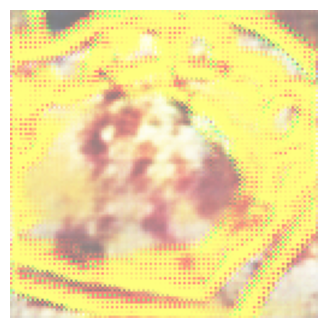

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data
data_path = "/export/space0/yanai/media/foodimg128/omurice/hed0999.png"
img = read_image(transform_for_sketch(data_path))
img = img.unsqueeze(0).to(device).float()

# model
model = Generator()
model.load_state_dict(torch.load("9_1_pix2pix_unet.pth"))
model = nn.DataParallel(model.to(device))

model.eval()
with torch.no_grad():
    styled_img = model(img)

# 可視化
def reprocessing(img):
    if img.ndim == 3:      # (C,H,W) → (1,C,H,W) に合わせる
        img = img.unsqueeze(0)
    img = (img + 1.) / 2.
    mean = torch.tensor([0.5, 0.5, 0.5], device=img.device).view(1,3,1,1)
    std  = torch.tensor([0.5, 0.5, 0.5], device=img.device).view(1,3,1,1)
    img = img * std + mean              
    return img.clamp(0,1).squeeze(0) #clamp()は念の為

vis = reprocessing(styled_img)
plt.figure(figsize=(4,4))
plt.imshow(vis.cpu().permute(1,2,0))
plt.axis('off')
plt.show()